# 数据准备

## 图片分块

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99680256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


unique mask=  [1 2 3 4 5]


d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99680256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


len(image_dataset) =  1521
len(mask_dataset) =  1521
image_dataset.shape=  (1521, 256, 256, 3)
mask_dataset.shape=  (1521, 256, 256)
image_number = 772


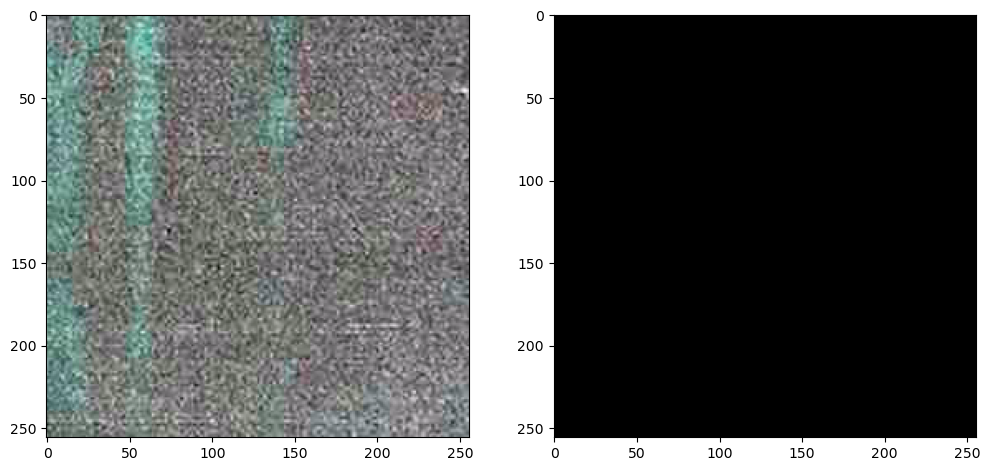

In [1]:
import os
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ['SM_FRAMEWORK'] = 'tf.keras'

from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = MinMaxScaler()
root_directory = 'D:\Projects\VsCode\Python\img_processing_system\change_detection\imgs\post_classification_comparison'
os.chdir(root_directory)
patch_size = 256

# 将训练图片分成小块
image_dataset = []  
image = cv2.imread(r"images\2012\14-2012-0445-6920-LA93-0M50-E080.tif", 1) #Read each image as BGR
SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
image = Image.fromarray(image)
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
image = np.array(image)             

#Extract patches from each image
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

#处理每个patch
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler\
            .fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1]))\
            .reshape(single_patch_img.shape)
        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
        image_dataset.append(single_patch_img)

# 对label图片做同样的处理
mask_dataset = []  
mask = cv2.imread(r"labels\2012\14-2012-0445-6920-LA93-0M50-E080.tif", cv2.IMREAD_UNCHANGED)  #Read each image as Grey (or color but remember to map each color to an integer)
print("unique mask= ",np.unique(mask))
#mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
mask = Image.fromarray(mask)
mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
mask = np.array(mask)    

#Extract patches from each image
patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #Step=256 for 256 patches means no overlap
for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
        single_patch_mask = patches_mask[i,j,:,:]
        mask_dataset.append(single_patch_mask) 

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)  
mask_dataset = mask_dataset - 1 # 模型预测需要label从0开始

print("len(image_dataset) = ", len(image_dataset))
print("len(mask_dataset) = ", len(mask_dataset))
print("image_dataset.shape= ", image_dataset.shape)
print("mask_dataset.shape= ", mask_dataset.shape)


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))  # 随机的image_number
plt.figure(figsize=(12, 6))
plt.subplot(121)
print("image_number =", image_number)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(mask_dataset[image_number], cmap='gray')
plt.show()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 42)


In [2]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

# move model to device
model.to(device)

# 误差函数和优化器
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 训练模型

In [ ]:
n_epochs = 20
batch_size = 2
for epoch in range(n_epochs):
    model.train()
    latest_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i+batch_size]    # batch_X shape (N, H, W, C)
        batch_y = y_train[i : i+batch_size]    # batch_y shape (N, H, W)

        # convert to torch tensors with correct shapes/dtypes:
        # inputs.shape= (N, C, H, W), dtype= float32
        inputs = torch.tensor(batch_X, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # targets -> (N, H, W), long (required by CrossEntropyLoss)
        targets = torch.tensor(batch_y, dtype=torch.long).to(device) # targets.shape =[10, 256, 256]
        optimizer.zero_grad()

        outputs = model(inputs)  # outputs shape: (N, num_classes, H, W) , outputs.shape= [10, 5, 256, 256]
        loss = loss_fn(outputs, targets) 
        loss.backward()
        optimizer.step()

        latest_loss = loss.item()

    print(f'Finished epoch {epoch}, latest loss {latest_loss}')

Finished epoch 0, latest loss 0.27083224058151245
Finished epoch 1, latest loss 0.20295286178588867
Finished epoch 2, latest loss 0.16941899061203003
Finished epoch 3, latest loss 0.1412348747253418
Finished epoch 4, latest loss 0.15524576604366302
Finished epoch 5, latest loss 0.14412523806095123
Finished epoch 6, latest loss 0.15579140186309814
Finished epoch 7, latest loss 0.15484194457530975
Finished epoch 8, latest loss 0.1355530172586441
Finished epoch 9, latest loss 0.1600138545036316
Finished epoch 10, latest loss 0.1399935483932495
Finished epoch 11, latest loss 0.1275496631860733
Finished epoch 12, latest loss 0.1532900333404541
Finished epoch 13, latest loss 0.12429473549127579
Finished epoch 14, latest loss 0.1202869638800621
Finished epoch 15, latest loss 0.13520130515098572
Finished epoch 16, latest loss 0.11024509370326996
Finished epoch 17, latest loss 0.1389676332473755
Finished epoch 18, latest loss 0.1164025291800499
Finished epoch 19, latest loss 0.10527554154396057

# 保存模型

In [5]:
torch.save(model, 'D:\Projects\VsCode\Python\img_processing_system\change_detection\models\post_classification_comparison_v2.pth')
model.eval()
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# 加载模型

In [2]:
model = torch.load('D:\Projects\VsCode\Python\img_processing_system\change_detection\models\post_classification_comparison_v2.pth', weights_only=False)
model.eval()
model.to(device)

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# 模型测试

test_img.shape=  (256, 256, 3)
input_tensor.shape = torch.Size([1, 3, 256, 256])
predicted_img unique val=  [0 1]
ground_truth unique val=  [0 1 2]


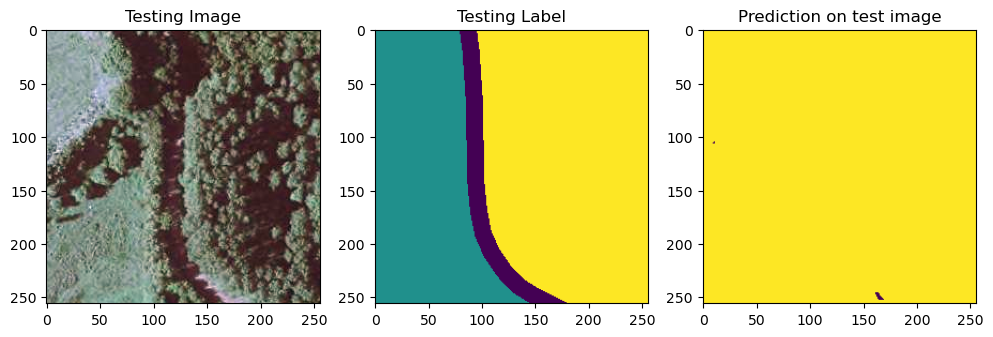

              precision    recall  f1-score   support

           0       0.74      0.01      0.01      4548
           1       0.36      1.00      0.53     23543
           2       0.00      0.00      0.00     37445

    accuracy                           0.36     65536
   macro avg       0.37      0.33      0.18     65536
weighted avg       0.18      0.36      0.19     65536



d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]

ground_truth = y_test[test_img_number]
# 如何把test_img交给模型来预测？
# 答：给test_img增加一个维度，然后调换维度的顺序
print("test_img.shape= ", test_img.shape) # test_img.shape=  (256, 256, 3)

# prepare input tensor: from (H, W, C) --> (1, C, H, W)
input_tensor = torch.tensor(test_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
print("input_tensor.shape =", input_tensor.shape)  # input_tensor.shape = (1, 3, 256, 256)

# run inference (no .predict for PyTorch modules)
model.eval()
with torch.no_grad():
	outputs = model(input_tensor)  # outputs.shape: (1, num_classes, H, W), 元素的取值：小数
	# convert logits to per-pixel class labels [0..4]
	predicted_img = outputs.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8) 

print("predicted_img unique val= ", np.unique(predicted_img))
print("ground_truth unique val= ", np.unique(ground_truth))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(ground_truth.flatten(), predicted_img.flatten()))

## 模型表现：对输入的图片中数据量较大的类预测比较准，但是如果某些类数据量远小于数据量最多的其他类，那么对这些类的预测效果很差。但是数据量大的类预测可能也不准，如下：
   precision    recall  f1-score   support  

0       0.74      0.01      0.01      4548  
1       0.36      1.00      0.53     23543  
2       0.00      0.00      0.00     37445  

# 评估模型

In [3]:
outputs = model(torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)) #outputs.shape= [261, 5, 256, 256]
final_outputs = outputs.argmax(dim=1).squeeze().cpu()

## 平均IOU

In [6]:
from keras.metrics import MeanIoU
miou = MeanIoU(num_classes=5)
miou.update_state(torch.tensor(y_test), final_outputs)
print("Mean IOU = ", miou.result().numpy())

Mean IOU =  0.16924028


## 计算单个类的IOU

In [ ]:
def iou_for_class(pred, gt, class_id):
    # 预测和真实的二值掩码
    pred_mask = (pred == class_id)
    gt_mask   = (gt == class_id)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return float('nan')  # 说明这个类在GT和预测中都不存在
    else:
        return intersection / union
    
for i in range(0, 5):
    print("{cls} class iou: {iou}".format(cls=i, iou = iou_for_class(final_outputs, torch.tensor(y_test), i)))

0 class iou: 0.014757396653294563
1 class iou: 0.8314440250396729
2 class iou: 0.0
3 class iou: 0.0
4 class iou: 0.0


In [ ]:
# 统计训练数据中不同类别的数据量
values, counts = np.unique(y_train, return_counts=True)
for e in zip(values, counts):
    print(e)

(0, 10609509)
(1, 74610934)
(2, 3660625)
(3, 210324)
(4, 561856)
